# pyphysio tutorial

## 3. Pipelines

In this tutorial we consider a pipeline for the processing of Blood Pulse (BP) signals.

We divide the pipelines into three separate steps:
1. Filtering and Preprocessing: this step includes all the procedures aiming at increasing the signal/noise ratio, typycally band-pass filtering, smoothing, removal of artifacts. The output of this step is a new version of the imput signal with improved signal quality (less noise);
2. Information Extraction: this step aims at extracting the information of interest from the physiological signal. The output is a new signal containing only the information of interest.
3. Physiological Indicators: this steps produces a list of scalar values able to describe the characteristics of the input signal. This step is usually performed on small segments of the input signals which are extracted using a sliding window on the whole length of the signal.

![algorithm](img/flowchart_processing.png)

*Figure 1: Representation of the three main steps of a signal processing pipeline. Below: example of the ideal results of each block on a Photo-PlethysmoGraph (PPG) signal. *

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#%matplotlib auto

In [2]:
# import all pyphysio classes and methods
import pyphysio as ph

Using dask. Scheduler: threads
Please cite:
Bizzego et al. (2019) 'pyphysio: A physiological signal processing library for data science approaches in physiology', SoftwareX


## Step 0: Import sample data

In [5]:
# import data and creating a signal
from pyphysio import TestData
bvp_data = TestData.bvp()

fsamp = 2048
bvp = ph.create_signal(bvp_data, sampling_freq = fsamp)

In [6]:
#bvp.plot()

To better understand how to develop a signal processing pipelines we imagine that the physiological signals were collected during an experiment in which the subject watched two images with different emotional content.

Specifically the experiment is composed of four parts:
* [  0s -  30s] - baseline
* [ 30s -  60s] - image 1
* [ 60s -  90s] - baseline
* [ 90s - 120s] - image 2

We store the information about the experimental sessions in an `EvenlySignal` signal appositely created:

In [7]:
# create label
label = np.zeros(1200)
label[300:600] = 1
label[900:1200] = 2

label = ph.create_signal(label, sampling_freq = 10)

## Step 1: Filtering and preprocessing

In [8]:
from pyphysio.filters import IIRFilter
# (optional) IIR filtering : remove low frequency noise
bvp = IIRFilter(fp=0.5, fs = 0.05, ftype='ellip')(bvp)

In [9]:
#bvp.plot()

## Step 2: Information Extraction: beat detection

The information we want to extract from the BP signal is the position of the peaks and the Inter Beat Interval signal.

In [14]:
from pyphysio.specialized.heart import BeatFromBP
ibi = BeatFromBP()(bvp)
ibi= ibi.p.process_na('remove')

/mnt/raidpool/UniTn/software/pyphysio/pyphysio/signal.py:330: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "o-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(t_, _np.squeeze(v_), marker, linestyle = linestyle)


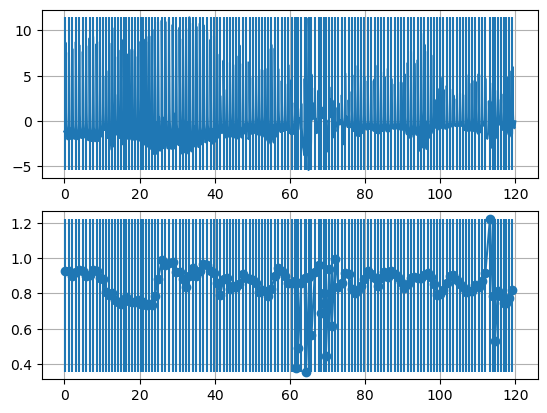

In [15]:
# check results so far
ax1 = plt.subplot(211)
bvp.p.plot()
plt.vlines(ibi.p.get_times(), bvp.p.get_values().min(), bvp.p.get_values().max())

plt.subplot(212, sharex = ax1)
ibi.p.plot('o-')
plt.vlines(ibi.p.get_times(), ibi.p.get_values().min(), ibi.p.get_values().max())
plt.show()

The central part of the signal presents artifacts due to movement.
It is possible to manually edit the detected beats with the `Annotate` class.

The inputs of this class are the signal used to detect the beats and the computed IBI signal (to be corrected).

It will show two plots:
1. The signal with vertical bars indicating the positions of the detected peaks.
2. The IBI signal

When moving the mouse over the first plot, two black vertical lines appear, to indicate the range of action.
When left-click on the first plot:
1. If a detected beat is present within the range of action, it is selected and colored green. If more than one beat is present, the nearest to the mouse pointer will be selected. The selected beat can be removed by pressing the 'd' key.
2. If no beat is present, a new beat is placed, corresponding to the instant of maximum within the range of action.

Scrolling the mouse wheel will increase/decrease the range of action.

Closing the window will conclude the operation and return the corrected ibi.

Note that the second plot will not change. It can be useful to quickly visualize the portions with beat detection errors.


**NOTE: on previous versions of jupyter and spyder the following code throwed some errors.**

**It works with jupyter v2.1.5**

In [16]:
%matplotlib auto
ibi_corrected = ph.Annotate(bvp, ibi).ibi_ok

Using matplotlib backend: <object object at 0x7f3634339210>


AttributeError: module 'pyphysio' has no attribute 'Annotate'

In [ ]:
ibi_corrected.plot()

When one (or more) beats could not be detected, e.g., due to noise, then the corresponding IBI is wrong (the IBI is computed between consecutive beats: if a beat is missing, the beats used to compute the IBI are not consecutive in the reality).

In this case (and in other cases when working with noisy signals) it might be useful to perform a step to remove the wrong beats. 
An algorithm is available in pyphysio that detects outliers.

This algorithm stores in a cache the last N valid IBIs. A new IBI is accepted if the difference between its value and the median of the IBIs stored in the cache is $(1-sens)*IBImedian <= IBI value <= (1+sens)*IBImedian$.
N and sens are the two parameters of the algorithm.

A second algorithm removes the wrong IBIs.

In [ ]:
id_wrong_ibi = ph.BeatOutliers()(ibi_corrected)

In [ ]:
id_wrong_ibi

In [ ]:
ibi_no_outliers = ph.FixIBI(id_wrong_ibi)(ibi_corrected)

In [ ]:
ibi_no_outliers.plot('.')

## Step 3: Physiological Indicators

In [ ]:
# check label
ax1 = plt.subplot(211)
ibi_no_outliers.plot('.')

plt.subplot(212, sharex = ax1)
label.plot('.')
plt.show()

In [ ]:
# define a list of indicators we want to compute
hrv_indicators = [ph.Mean(name='RRmean'), ph.StDev(name='RRstd'), ph.RMSSD(name='rmsSD')]

In [ ]:
#fixed length windowing
fixed_length = ph.FixedSegments(step = 5, width = 10, timeline = label)
fmap_results = ph.fmap(fixed_length, hrv_indicators, ibi)

In [ ]:
results = ph.indicators2df(fmap_results)
display(results)